Importing necessary libraries

In [1]:
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
%matplotlib inline

Setting random seed for reproducibility

In [2]:
tf.random.set_seed(272)

Setting image size and loading pretrained VGG19 model

In [3]:
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet'
                                  )

vgg.trainable = False
print(vgg)

80134624/80134624 [==============================] - 1s 0us/step


Loading content image

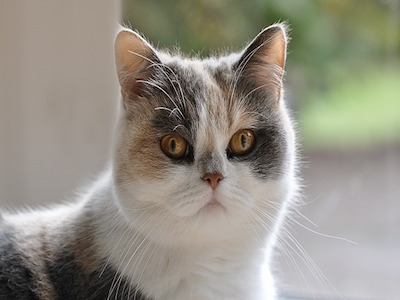

In [4]:
content_image = Image.open("images/content.jpg")
content_image

Function to compute content cost

In [5]:
def compute_content_cost(content_output, generated_output):
    a_C = content_output[-1]
    a_G = generated_output[-1]

    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_C_unrolled = tf.transpose(tf.reshape(a_C, shape=[m, -1, n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G, shape=[m, -1, n_C]))

    J_content =  (1 / (4 * n_H * n_W * n_C)) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))

    return J_content

Testing compute_content_cost function

In [6]:
tf.random.set_seed(1)
a_C = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_content = compute_content_cost([a_C], [a_G])
J_content_0 = compute_content_cost([a_C], [a_C])

print("J_content = " + str(J_content))

ll = tf.keras.layers.Dense(8, activation='relu', input_shape=(1, 4, 4, 3))
model_tmp = tf.keras.models.Sequential()
model_tmp.add(ll)


J_content = tf.Tensor(7.056877, shape=(), dtype=float32)


Loading Style Image

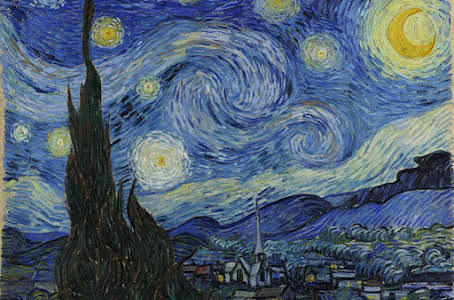

In [7]:
style_image = Image.open("images/style.jpg")
style_image

Function to compute Gram matrix

In [8]:
def gram_matrix(A):
    GA = tf.matmul(A, A, transpose_b=True)
    return GA

Testing gram_matrix function

In [9]:
tf.random.set_seed(1)
A = tf.random.normal([3, 2 * 1], mean=1, stddev=4)
GA = gram_matrix(A)

print("GA = \n" + str(GA))

GA = 
tf.Tensor(
[[ 63.188793  -26.721273   -7.7320204]
 [-26.721273   12.76758    -2.5158243]
 [ -7.7320204  -2.5158243  23.752384 ]], shape=(3, 3), dtype=float32)


Function to compute style cost for a layer

In [10]:
def compute_layer_style_cost(a_S, a_G):

    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = (1 / (4 * n_C **2 * (n_H * n_W) **2)) * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))
    return J_style_layer

Testing compute_layer_style_cost function

In [11]:
tf.random.set_seed(1)
a_S = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_style_layer_GG = compute_layer_style_cost(a_G, a_G)
J_style_layer_SG = compute_layer_style_cost(a_S, a_G)

print("J_style_layer = " + str(J_style_layer_SG))

ll = tf.keras.layers.Dense(8, activation='relu', input_shape=(4, 4, 3))
model_tmp = tf.keras.models.Sequential()
model_tmp.add(ll)


J_style_layer = tf.Tensor(14.017804, shape=(), dtype=float32)


Extracting layer names from VGG model

In [12]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Selecting a specific layer from the VGG model

In [13]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

Defining style layers and their weights

In [14]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

Function to compute style cost for all layers

In [15]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    J_style = 0

    a_S = style_image_output[:-1]
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])
        J_style += weight[1] * J_style_layer

    return J_style

Total cost function (content + style)

In [16]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):

    J = alpha * J_content + beta * J_style

    return J

Testing total_cost function

In [17]:
J_content = 0.2
J_style = 0.8
J = total_cost(J_content, J_style)

np.random.seed(1)
print("J = " + str(total_cost(np.random.uniform(0, 1), np.random.uniform(0, 1))))

J = tf.Tensor(32.9832, shape=(), dtype=float32)


Loading and preprocessing content, style, and generated images

(1, 400, 400, 3)


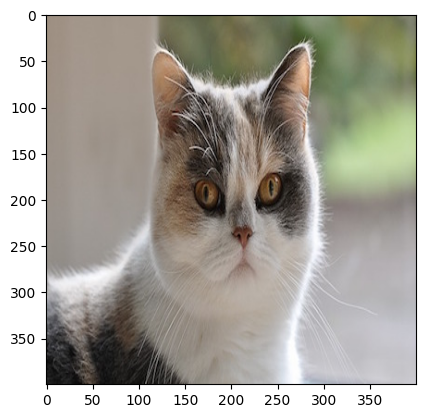

In [18]:
content_image = np.array(Image.open("images/content.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


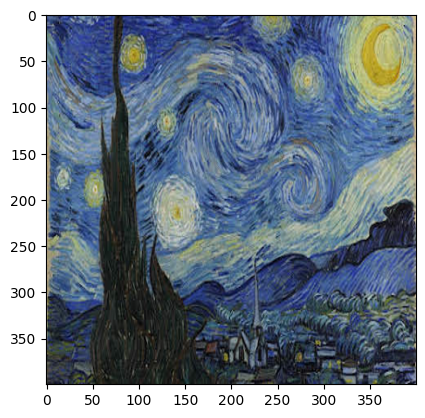

In [19]:
style_image =  np.array(Image.open("images/style.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


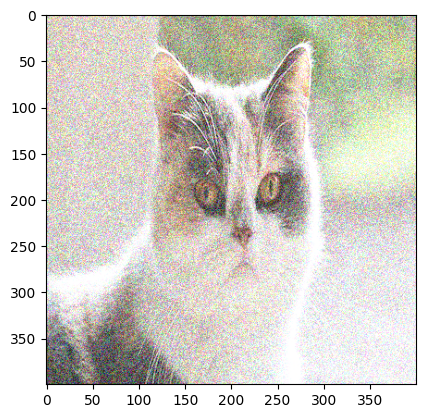

In [20]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.5)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

Function to get layer outputs for specified layers

In [21]:
def get_layer_outputs(vgg, layer_names):
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

Selecting content layer for content loss

In [22]:
content_layer = [('block5_conv4', 1)]

Getting layer outputs for style and content images

In [23]:
vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)
content_target = vgg_model_outputs(content_image)
style_targets = vgg_model_outputs(style_image)

Preprocessing content image for VGG model

In [24]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

Getting layer outputs for generated image

In [25]:
a_G = vgg_model_outputs(generated_image)

Computing content cost

In [26]:
J_content = compute_content_cost(a_C, a_G)

print(J_content)

tf.Tensor(0.006907556, shape=(), dtype=float32)


Preprocessing style image for VGG model

In [27]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)


Computing style cost

In [28]:
J_style = compute_style_cost(a_S, a_G)
print(J_style)

tf.Tensor(1050.1075, shape=(), dtype=float32)


Function to clip pixel values to the range [0, 1]

In [29]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Function to convert tensor to image

In [30]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

Adam optimizer for training

In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.03)

In [32]:
@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        a_G = vgg_model_outputs(generated_image)
        J_style = compute_style_cost(a_S, a_G)
        J_content = compute_content_cost(a_C, a_G)
        J = total_cost(J_content, J_style)

    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    return J

In [33]:
# Initializing generated image
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

# Testing a single training step
J1 = train_step(generated_image)
print(J1)
J2 = train_step(generated_image)
print(J2)


tf.Tensor(17734.078, shape=(), dtype=float32)
tf.Tensor(8060.563, shape=(), dtype=float32)


Training loop

Epoch 0 


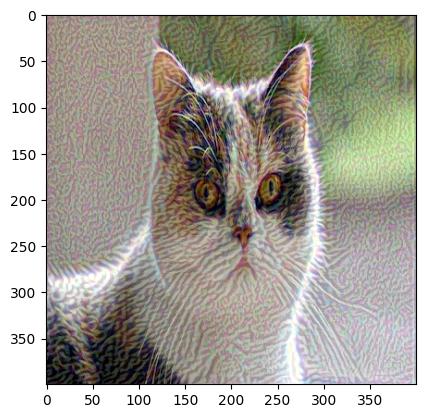

Epoch 500 


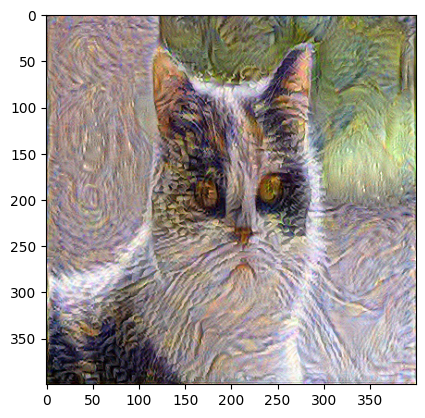

Epoch 1000 


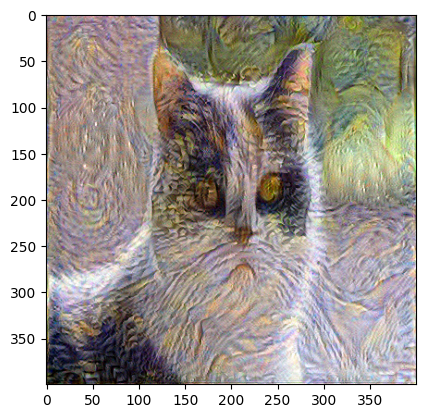

Epoch 1500 


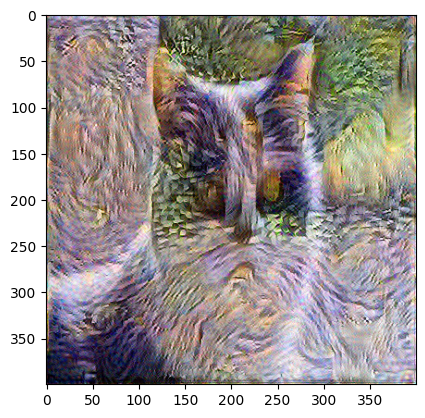

Epoch 2000 


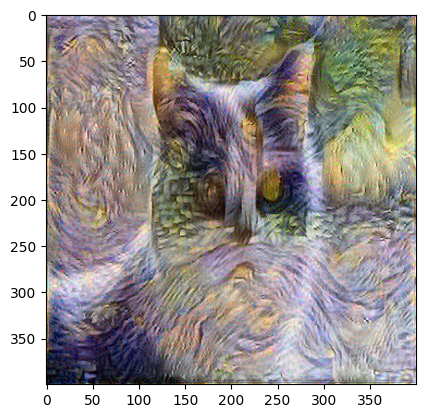

Epoch 2500 


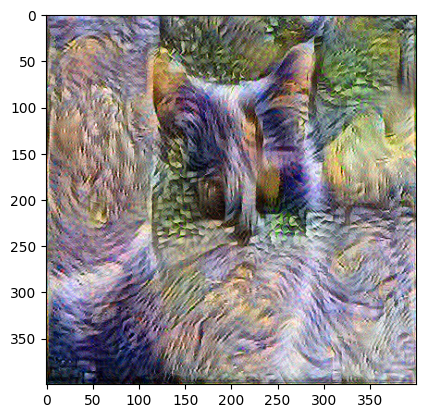

Epoch 3000 


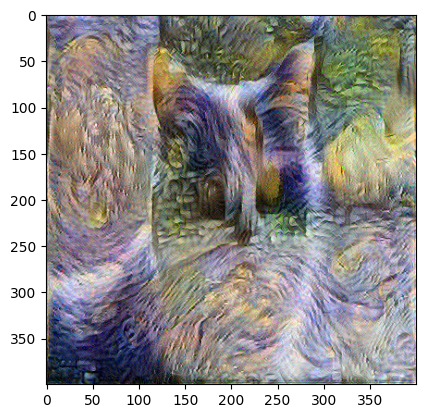

In [34]:
epochs = 3001
for i in range(epochs):
    train_step(generated_image)
    if i % 500 == 0:
        print(f"Epoch {i} ")
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"outputs/image_{i}.jpg")
        plt.show()


Function to compute content loss

In [35]:
def contentLoss(content_image, generated_image):
    # Normalizing images to [0, 1]
    content_image = tf.image.convert_image_dtype(content_image, tf.float32)
    generated_image = tf.image.convert_image_dtype(generated_image, tf.float32)

    # Calculating the Gram matrix for each image
    content_features = gram_matrix(content_image)
    generated_features = gram_matrix(generated_image)

    # Calculating the L2 norm between the Gram matrices
    content_loss = tf.reduce_mean(tf.square(content_features - generated_features))

    return content_loss

Function to compute Gram matrix

In [36]:
def gram_matrix(image):
    # Extracting features from the image
    features = vgg(image)

    # Reshape the features to [num_channels, num_pixels]
    features = tf.reshape(features, [-1, tf.shape(features)[-1]])

    # Calculating the Gram matrix
    gram_matrix = tf.matmul(features, features, transpose_b=True)

    return gram_matrix

Preprocessing Content, Style and Generated images

In [37]:
content_image = Image.open("images/content.jpg")
style_image = Image.open("images/style.jpg")
generated_image = Image.open("outputs/image_3000.jpg")

resized_content_image = tf.image.resize(content_image, (400, 400))
resized_style_image = tf.image.resize(style_image, (400, 400))
resized_generated_image = tf.image.resize(generated_image, (400, 400))

resized_content_image = tf.expand_dims(resized_content_image, axis=0)
resized_style_image = tf.expand_dims(resized_style_image, axis=0)
resized_generated_image = tf.expand_dims(resized_generated_image, axis=0)

content_loss = contentLoss(resized_content_image, resized_generated_image).numpy()
style_loss = contentLoss(resized_style_image, resized_generated_image).numpy()

In [38]:
print("Content loss:", content_loss)

Content loss: 244644020.0


In [39]:
print("Style loss:", style_loss)

Style loss: 74710060.0


Printing whether content loss is greater than style loss

In [40]:
print(content_loss>style_loss)

True


#### Limitations and Potential Improvements
- The weighting of content and style terms (alpha and beta) is fixed in this implementation. However, optimal values may vary depending on the content and style images, and finding a universally effective balance can be challenging.
- The model may not always preserve fine details in the content image, and the stylized output might lack some intricacies present in the original content.
- Defining and using more comprehensive evaluation metrics to assess the quality of stylized images. This could involve human studies, perceptual metrics, or domain-specific metrics.
- Investigating methods to incorporate semantic information into the style transfer process, ensuring that the model pays attention to important objects and structures in the content image.